In [32]:
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from tabulate import tabulate

import scipy.constants as const
from scipy.optimize import fsolve

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from numpy.polynomial.chebyshev import Chebyshev
from numpy.polynomial.chebyshev import chebfit, chebval

import uncertainties as unc
import lmfit as lm


import seaborn as sns
sns.set_context("paper")
main_dir = os.getcwd()


In [33]:
def FlipLegend(ax, title, loc='best', ncols=1, prop=None):
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1],
              title=title, loc=loc, ncol=ncols,
              prop=prop)

Here we are seeking the magnetoresistivity (MR) $\left(\rho_{MR}\right)$ of the sample as a function of the magnetic flux density $\left(\rho\left(B\right)\right)$ at 2K, 5K, 10K and 15K in the fields 0.5T, 3T, 7T and 9T. We will then compare $\rho$ values against the AMRO resistivity at sample orientations 0 and 90 degrees. Since $B$ is dependent on the demagnetization factor $\left(D\right)$ via,

(SI) 

$B = \mu_0\left(H + M-M_D\right) = \mu_0\left(H + (1-D)M\right)$ 

(CGS) 

$B =  H + 4\pi (M-M_D) = H + 4\pi(1-D)M$

where $M$ is the magnetization per volume, which we obtain via the magnetic moment $(m)$ measured in Brazil. 

Thus we must determine the MR data $(\rho_{MR})$ as a function of total magnetic flux $(B)$, using the magnetization data. Then we will calculate the $B$ values for the AMRO data at two orientations, $90^\circ$ and $0^\circ$, making use of the magnetization calculations.

Unfortuantely, since we don't have magnetization data for the samples that were used to take the AMRO and MR data, we must assume that the volume magnetization will be constant between these samples so long as the applied magnetic field $H$ is the same.

This document will work in CGS units for all calculations, until it is time to make nice graphs.

Source: https://en.wikipedia.org/wiki/Demagnetizing_field

# Define Demagnetization Factor Function and Constants

In [34]:
def DFactor(a,b,c):
    '''
        c must be parallel to the applied magnetic field.
        
        Finds the demagnetizing factor for a rectangular prism onto which a
        magnetic field is applied. The field is assumed to be applied parallel
        to the z-axis, and therefore perpendicularly to the x- and y-axes.
        
        The values of the input variables are taken to be half the length
        of the rectangular prism, with one length for each spatial dimension.
        -a < x < a
        -b < y < b
        -c < z < c
        
        Thus, each a, b, and c are half the sample length in each direction.
    '''
    return (1/np.pi)*(((b**2 - c**2)*np.log((np.sqrt(a**2 + b**2 + c**2) - a)/(np.sqrt(a**2 + b**2 + c**2) + a)))/
      (2*b*c) + ((a**2 - c**2)*np.log((np.sqrt(a**2 + b**2 + c**2) - b)/(np.sqrt(a**2 + b**2 + c**2) + b)))/(2*a*c) + 
     (b*np.log((np.sqrt(a**2 + b**2) + a)/(np.sqrt(a**2 + b**2) - a)))/(2*c) + 
     (a*np.log((np.sqrt(a**2 + b**2) + b)/(np.sqrt(a**2 + b**2) - b)))/(2*c) + 
     (c*np.log((np.sqrt(b**2 + c**2) - b)/(np.sqrt(b**2 + c**2) + b)))/(2*a) + 
     (c*np.log((np.sqrt(a**2 + c**2) - a)/(np.sqrt(a**2 + c**2) + a)))/(2*b) + 2*np.arctan((a*b)/(c*np.sqrt(a**2 + b**2 + c**2))) + 
     (a**3 + b**3 - 2*c**3)/(3*a*b*c) + ((a**2 + b**2 - 2*c**2)*np.sqrt(a**2 + b**2 + c**2))/(3*a*b*c) + 
     (c*(np.sqrt(a**2 + c**2) + np.sqrt(b**2 + c**2)))/(a*b) - ((a**2 + b**2)**(3/2) + (b**2 + c**2)**(3/2) + 
       (c**2 + a**2)**(3/2))/(3*a*b*c))


## Constants and Units

SI

$\mu_0 = 1.25663706212(19)×10^{−6} \frac{N}{A^2} \sim \left[\frac{kg m}{s^2A^2}\right]$

$H\sim \frac{A}{m}$

$B \sim Tesla \sim \frac{kg}{s^2A}$

$ M \sim \frac{A}{M} $

$m \sim \frac{J}{T}$

CGS

$H\sim Oerstad \rightarrow \frac{10^3}{4\pi}\frac{A}{m}$

$B \sim Gauss \rightarrow \frac{1}{10000} T$

$m \sim erg/G \rightarrow emu \rightarrow 10^3\frac{J}{T}$

$ M \sim \frac{erg}{G\cdot cm^3} =\frac{emu}{cm^3} \rightarrow 10^3\frac{A}{m}$

In [35]:
kb_SI  = const.Boltzmann  # J / K -> m^2 kg / s^2 / K
kb_CGS = kb_SI *10**(7) # erg/ K   [ 10^7 erg = J]
mub_SI = const.value(u'Bohr magneton')  # J/T
mub_CGS = mub_SI * 10**3 # erg / G
mu0_SI = const.value(u'vacuum mag. permeability')  # N/A^2
mu0_CGS = 1
Na = 6.0221408e+23  # atoms/mol


# Obtain M(B), Brazil Data

We require this magnetization data in order to calculate the total magnetic flux $(B)$ for the $\rho_{MR}$ data and the AMRO data. Making use of a Chebyshev polynomial, we interpolate the data such that we may plug in an arbitrary applied field $H$ and extract a magnetization at the given temperature at that field strength.

Since the Brazil data was unable to reach 9T, we will also fit a Brillouin function to calculate an approximate magnetization at 9T for each temperature.

## Load the Magnetization Data

In [36]:
# Magnetization
import_directory = r''
# 'Sample_Magnetization_Raphael'

sample_mass = 0.00268 # g
filenames = [x for x in os.listdir(import_directory) if '.dat' in x]


col_choice = ['Temperature (K)', 'Magnetic Field (Oe)', 'Moment (emu)', 'T']

mag_data = pd.DataFrame()

for name in filenames:
    pathname = os.path.join(import_directory, name)
    df = pd.read_table(pathname, skiprows=39, sep=',')
    
    name = [x.split('H')[1] for x in name.split('_') if 'MvH' in x][0]
    print(name)
    df['T'] = int(name[:-1])
    df.dropna(axis=1, inplace=True, how='all')
    
    mag_data = pd.concat([mag_data, df])#, axis=1)
    
mag_data = mag_data[col_choice]



15K
10K
2K
5K


In [37]:
print(mag_data.query('T==2'))

     Temperature (K)  Magnetic Field (Oe)  Moment (emu)  T
0           1.999880            -0.355470     -0.000003  2
1           2.000213           700.226379      0.001555  2
2           1.999879          1400.293335      0.003106  2
3           1.999896          2100.311523      0.004645  2
4           2.000028          2800.378418      0.006166  2
..               ...                  ...           ... ..
96          1.999876         67200.382812      0.069587  2
97          2.000059         67900.273438      0.069906  2
98          2.000090         68600.429688      0.070080  2
99          1.999897         69300.312500      0.070410  2
100         1.999768         70000.414062      0.070771  2

[101 rows x 4 columns]


## Calculate $B(M_{vol})$ for the Magnetization Data

We will calculate the volume magnetization from the data, and multiply by $4\pi$ in order to obtain the magnetization field, which replace the magnetization term in the equation for $B$

In [38]:
# Define the dimensions of the sample used
a_Brazil = 0.21070 # cm
b_Brazil = 0.08766  # cm
c_Brazil = 0.09315  # cm, B-Field ||

volume_Brazil = a_Brazil*b_Brazil*c_Brazil  # cm^3
D_factor_Brazil = DFactor(a_Brazil/2.0, b_Brazil/2.0, c_Brazil/2.0)

mass_density_YbPdBi = 11.396  #  g/cm^3, determined from XRD

volume_brazil2 = sample_mass / mass_density_YbPdBi # g * (cm^3/g)

# print(volume_Brazil, volume_brazil2)
mag_data['Magnetization (emu/cm^3)'] = mag_data['Moment (emu)']  / volume_Brazil 
mag_data['Magnetization (emu/g)'] = mag_data['Moment (emu)']  / sample_mass 

mag_data['Magnetic Flux Density (G)']  = mag_data['Magnetic Field (Oe)'] + (4*np.pi)*(1-D_factor_Brazil) * mag_data['Magnetization (emu/cm^3)']


# Extrapolate M(B) to $\mu_0H=9$T

Since the data from Brazil has a maximum applied field strength of 7T, we need to approximate the magnetization at 9T in order to check demagnetization effects at this field strength.

## Try Fitting with J as a parameter

Mimic What was done in "Magnetization and Susceptibility.nb"

Mag. Moments per cm^3: 1.9205499885401072e+21
T = 2 , min residual: -75.6652820358606 , max residual: 0.5767042855312997


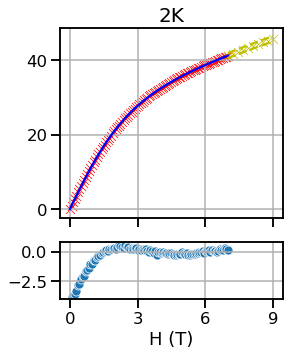

T = 5 , min residual: -97.48255312101517 , max residual: 0.36503225280567475


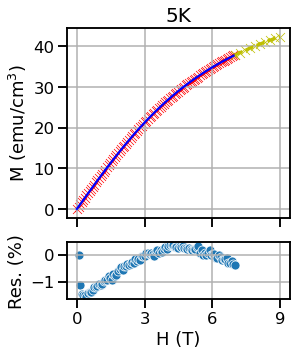

T = 10 , min residual: -98.88952750186577 , max residual: 2.681434589952345


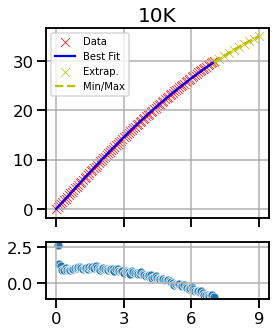

T = 15 , min residual: -101.89672965917617 , max residual: 3.1077374415033785


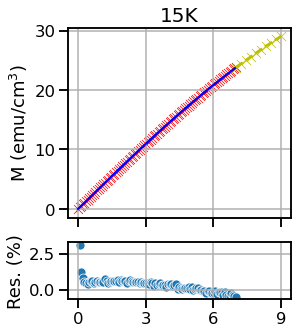

lmfit Fit Brillouin Results
          J     J err         C         C err             n         n err  \
3  2.686059  0.000606  0.000000  0.000000e+00  1.920550e+21  0.000000e+00   
2  2.494205  0.001183  0.000000  0.000000e+00  1.920550e+21  0.000000e+00   
1  1.916728  0.003237  0.000060  9.735505e-07  1.920550e+21  0.000000e+00   
0  1.449146  0.016191  0.000201  1.736073e-06  1.546257e+21  1.849605e+19   

      T         D         M0    M0 err     C (T)  C (T) err  n (mols)  \
3  15.0  0.400857  56.747540  0.010791  0.000000   0.000000  0.003189   
2  10.0  0.400857  53.330390  0.021079  0.000000   0.000000  0.003189   
1   5.0  0.400857  43.044828  0.057651  0.602009   0.009736  0.003189   
0   2.0  0.400857  27.950755  0.407053  2.010834   0.017361  0.002568   

   n (mols) err  
3      0.000000  
2      0.000000  
1      0.000000  
0      0.000031  




In [39]:
from uncertainties import ufloat
sample_mass = sample_mass  # g
molar_mass = 488.44  # g/mol
# density = 10.84  # g/cm^3, from material project
muB =  9.2740100783E-21  # emu = erg/G# mub_CGS  #
kb =  1.380649E-16  # erg/K

# number of magnetic moments per unit volume
nVol = (sample_mass / molar_mass*Na)/volume_Brazil
print('Mag. Moments per cm^3:', nVol)


S = 1/2  # 1/2

def g_j_Yb(J):
    L = J - S
    top = S*(S+1)-L*(L+1)
    bottom = 2*J*(J+1)

    # The 1 comes from Kittel, Blundell has 3/2 but that is equivalent based on his second term.
    g_j_Yb = 3/2 + top / bottom    
    return g_j_Yb
def BrillouinFunction_Yb_L(x, J):
        # J = L + S
        # L = J - S


        J1 = (2*J+1)/(2*J)
        J2 = 1/(2*J)
        
        coth1 = 1/np.tanh(J1*x)
        coth2 = 1/np.tanh(J2*x)

        Bj= J1*coth1 - J2*coth2

        return Bj


## SOLVE FOR Ms AS COEFFICIENT
def M_YbPdBi_Brill_forL(H, M, D, T, J, C, n):
    '''
    
        DOES THE DEMAGNETIZING FIELD ONLY APPLY TO FERROMAGNETS? Inv susceptibility implied
        that it is AFM?
        
        M0 : saturization magnetization
        H  : Applied Magnetic Field, but perhaps this should be magnetic flux density, B
        T  : Temperature
        A : Arbitrary scaling factor to absorb the details (since we just want a close fit)

        NOTE: May need to add a demagnetization factor to this,
                 B = H + 4\pi (1-D)M
               and solve it self-consistently, which would allow the inclusion of both B and 
               demagnetization effects...
               
        Both M0 and A are temeprature independent
        
        Maybe try and calculate a theoretical.
        
        Also check out eqn 5.6 and eqn 5.7, which showns the brillouin function for Weiss
        ferromagnetism.
    '''

    # J = L+S
    # M0 propto emu/cm^3)
    B = H+4*np.pi*(1-D)*M
    return n*g_j_Yb(J)*muB*J*BrillouinFunction_Yb_L(g_j_Yb(J)*muB*J*B/(kb*T), J) + C*H

    # return M0*BrillouinFunction_Yb(A*g_j_Yb*muB*J*B/(kb*T))
def Solve_for_M_w_L(H, D, T, J, C, n):
    ''' 
        Based on inputted values, we numerically solve this to extract a magnetization.
    '''
    if isinstance(H, float) or isinstance(H, int):
        def func(M):
            return M_YbPdBi_Brill_forL(H, M[0], D, T, J, C, n) - M[0]

        return fsolve(func, [20])[0]
    else:
        M_list = []
        for H in H:

            def func(M):
                return M_YbPdBi_Brill_forL(H, M[0], D, T, J, C, n) - M[0]

            M_list.append(fsolve(func, [20])[0])
        return M_list

#######################################################################################
#######################################################################################
#######################################################################################
# fig, axs = plt.subplots(2, 4, sharex=True, sharey=False, gridspec_kw={'height_ratios': [1, 0.25]})
# fig, axs = plt.subplots(4, 2, sharex=True, sharey=False)#, gridspec_kw={'height_ratios': [1, 0.5]})

x_label = 'Magnetic Field (Oe)'
y_label = 'Magnetization (emu/cm^3)'

D = D_factor_Brazil # D-factor is also fixed
lmfit_mag_results_lin_L = pd.DataFrame()
brill_fit_results_lmfit_lin_L = pd.DataFrame()


mag_func_dict = {}
H_ticks = np.linspace(0,9, 4)

for i, T in enumerate([2, 5, 10, 15]):
    sns.set_context('talk')
    fig, axs = plt.subplots(2,1, sharex=True, sharey=False, gridspec_kw={'height_ratios': [1, 0.3]})
    fig.set_size_inches(4,5)
    
    # Select relevant plotting axes
    fit_ax = axs[0]#[i]
    res_ax = axs[1]#[i]
    
    # Query the relevant magnetization data
    mag_hunt_df =  mag_data.query('T == {}'.format(T)).drop('Magnetic Flux Density (G)', axis=1)

    # Extract experimental data
    M_vals = mag_hunt_df[y_label].values
    H_vals = mag_hunt_df[x_label].values
    T_vals = mag_hunt_df['Temperature (K)'].values

    ###### FITTING #######
    # Create the Model, then declare independant variables and fit parameters
    gmodel = lm.Model(func = M_YbPdBi_Brill_forL, independent_vars = ['H','M', 'D', 'T'])#, param_names=['M0','A','C'])

    if T in ( 10, 15):
        gmodel.set_param_hint('C', value=0, vary=False)
        gmodel.set_param_hint('n', value=nVol, vary=False)
    elif T == 5:
        gmodel.set_param_hint('C', value=0, vary=True)
        gmodel.set_param_hint('n', value=nVol, vary=False)
    else:
        gmodel.set_param_hint('C', value=0, vary=True)
        gmodel.set_param_hint('n', value=nVol, vary=True)

    gmodel.set_param_hint('J', value=7/2, vary=True)

    # Perform the fit on the Model
    result = gmodel.fit(M_vals, H=H_vals, M=M_vals, D=D, T=T_vals)

    params_df = {}
    for key in result.params.keys():
        params_df[key] = result.params[key].value
        params_df[key+' err'] = result.params[key].stderr    
    params_df['T'] = float(T)
    params_df['D'] = D
    params_df = pd.DataFrame(params_df, index=[0])
    
    # Store params in a dataframe
    lmfit_mag_results_lin_L = pd.concat([lmfit_mag_results_lin_L, params_df])
    
    # Store function in dict to be called later with different H
    # NOTE: May not work since magnetization is on both sides...
    mag_func_dict[str(T)] = result.eval

    ###### EXTRAPOLATION #######
    H_interval = 5*int(H_vals[-1]-H_vals[-2])
    num_H_points = (90000 - max(H_vals))/H_interval
    fake_H_vals =  np.linspace(max(H_vals), 90000, 10)

    fake_M_vals = Solve_for_M_w_L(fake_H_vals, D, T,  
                                  params_df['J'].values[0],
                                  params_df['C'].values[0],
                                  params_df['n'].values[0])
    max_M_vals = Solve_for_M_w_L(fake_H_vals, D, T,  
                                 params_df['J'].values[0]+params_df['J err'], 
                                 params_df['C'].values[0]+params_df['C err'],
                                 params_df['n'].values[0]+params_df['n err'])
    min_M_vals = Solve_for_M_w_L(fake_H_vals, D, T,  
                                 params_df['J'].values[0]-params_df['J err'], 
                                 params_df['C'].values[0]-params_df['C err'],
                                 params_df['n'].values[0]-params_df['n err'])

    # Pack and Append Extrapolated Data
    temp_df = pd.DataFrame({'T': T,
                           'Temperature (K)': T,
                           'Magnetic Field (Oe)': fake_H_vals,
                            y_label : fake_M_vals,
                            y_label+"_err_max":max_M_vals,
                            y_label+"_err_min":min_M_vals}
                            )
    brill_fit_results_lmfit_lin_L = pd.concat([brill_fit_results_lmfit_lin_L, temp_df])       

    
    ###### PLOTTING #######
    # sns.set_context('paper')
    # Data
    sns.scatterplot(x= H_vals/10000, y=M_vals, marker='x', ax=fit_ax, color='r', label='Data')
    # Best Fit
    sns.lineplot(x=H_vals/10000, y = result.best_fit, ax=fit_ax, color='b', label='Best Fit')
    # Residuals
    print('T =', T, ', min residual:', min(result.residual/M_vals*100), ', max residual:', max(result.residual/M_vals*100))
    sns.scatterplot(x=H_vals[1:]/10000,
                    y=(result.residual/M_vals*100)[1:],
                    ax=res_ax)
    # Extrapolations
    sns.scatterplot(x= fake_H_vals/10000, 
                    y=fake_M_vals, 
                    marker='x', ax=fit_ax, color='y', label='Extrap.')
    sns.lineplot(x= fake_H_vals/10000, 
                 y=max_M_vals, 
                 color='y', marker='None', ax=fit_ax, linestyle='--', label='Min/Max')
    sns.lineplot(x= fake_H_vals/10000, 
                 y=min_M_vals, 
                 color='y', marker='None', ax=fit_ax, linestyle='--')
    

    # Do the formatting stuff
    fit_ax.legend(loc='best')#(0.55, 0.2))
    fit_ax.set_xticks(H_ticks)
    res_ax.set_xticks(H_ticks)
    
    fit_ax.set_ylabel(r'M (emu/cm$^3$)')
    res_ax.set_xlabel('H (T)')
    
    plot_title = str(T) 
    fit_ax.set_title(plot_title+"K", size=20)
    
    # Add gridlines
    fit_ax.grid()
    res_ax.grid()
    
    # Modify labels and legends for visual clarity
    if T == 2:
        fit_ax.legend().remove()
        fit_ax.set_ylabel(None)

    elif T == 5:
        fit_ax.legend().remove()
        res_ax.set_ylabel('Res. (%)')
    elif T == 10:
        fit_ax.legend(prop={'size':10})
        fit_ax.set_xlabel(None)
        res_ax.set_xlabel(None)
        fit_ax.set_ylabel(None)
        res_ax.set_ylabel(None)
        

    elif T == 15:
        fit_ax.legend().remove()
        fit_ax.set_xlabel(None)
        res_ax.set_xlabel(None)
        res_ax.set_ylabel('Res. (%)')
        
    # i+=1
    fig.savefig('Brillouin Fits and Extrapolation, Linear Term with L {}K.pdf'.format(T), dpi=300, transparent=False, bbox_inches='tight')
    plt.show()

# Calc saturization magnetization 
M = []
M_err = []
for i, row in lmfit_mag_results_lin_L.iterrows():
    
    n = ufloat(row['n'], row['n err'])
    J = ufloat(row['J'], row['J err'])
    
    M0 = n*g_j_Yb(J)*muB*J

    M.append(M0.nominal_value)
    M_err.append(M0.std_dev)
    
lmfit_mag_results_lin_L['M0'] =  M #lmfit_mag_results_lin_L['n']*g_j_Yb(lmfit_mag_results_lin_L['J'])*muB*lmfit_mag_results_lin_L['J']
lmfit_mag_results_lin_L['M0 err'] =  M_err     

lmfit_mag_results_lin_L['C (T)'] = lmfit_mag_results_lin_L['C']*10000
lmfit_mag_results_lin_L['C (T) err']= lmfit_mag_results_lin_L['C err']*10000

lmfit_mag_results_lin_L['n (mols)'] = lmfit_mag_results_lin_L['n']/Na
lmfit_mag_results_lin_L['n (mols) err']= lmfit_mag_results_lin_L['n err']/Na


lmfit_mag_results_lin_L.reset_index(drop=True, inplace=True)    
brill_fit_results_lmfit_lin_L.reset_index(drop=True, inplace=True)
# pd.options.display.float_format = '{:.0f}'.format

print("lmfit Fit Brillouin Results")
print(lmfit_mag_results_lin_L.sort_values('T', ascending=False))
print('\n')
    


### Plot the Fit Parameters

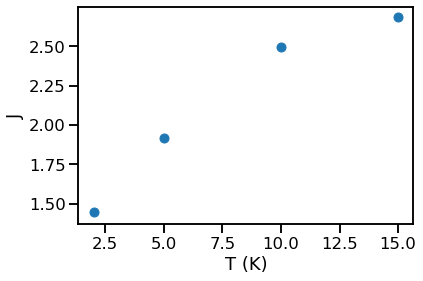

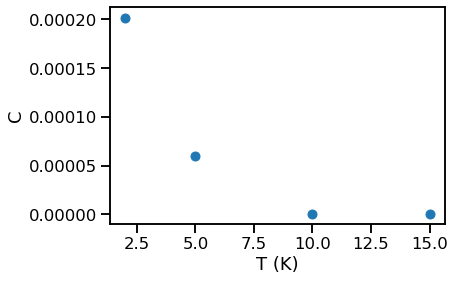

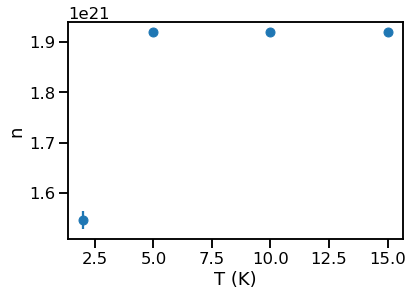

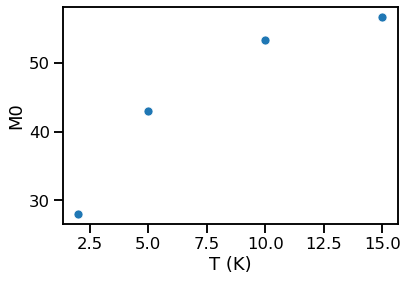

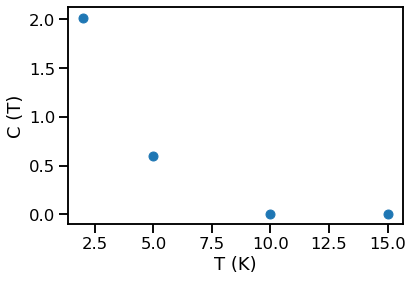

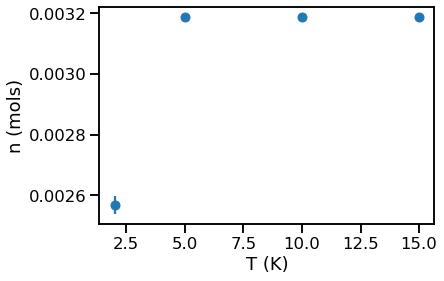

In [40]:

for col in lmfit_mag_results_lin_L.columns:
    if col == 'M0':
        x_vals = lmfit_mag_results_lin_L['T'].values
        y_vals = lmfit_mag_results_lin_L[col].values
        sns.scatterplot(x=x_vals,
                         y=y_vals)
        plt.gca().set(ylabel=col, xlabel='T (K)')
        plt.show()  
    elif col not in ('C err', 'n err', 'J err','M0 err', 'C (T) err', 'n (mols) err', 'T', 'D'):
        
        x_vals = lmfit_mag_results_lin_L['T'].values
        y_vals = lmfit_mag_results_lin_L[col].values
        y_errs = lmfit_mag_results_lin_L[col+' err'].values
        plt.errorbar(x=x_vals,
                     y=y_vals,
                     yerr=y_errs,
                     linestyle='None', marker='o')
        plt.gca().set(ylabel=col, xlabel='T (K)')
        plt.show()

## Extract Best Parameters, and also the Magnetizations at H=9T

The best choice of model for each temperature range is evident from the plotted fits and residuals. The regular Brillouin fit describes the higher temperature data well and the lower temeprature data poorly. This makes sense considering the limitations of the mean-field Curie-Weiss model\cite{Blundell}. The converse is the case for the phenomenological model which has the linear term: the lower temperature data is described better than the higher temperature data. In all cases, the fits residuals seem to diverge as $H\rightarrow 0T$, but fortunately we are desire these fits only to extrapolate to $H=9T$.

Therefore, for $M(H)$ data taken at 2K we shall make use of the phenomenological model which involves the linear term, and for $M(H)$ data taken at 5K, 10K, and 15K we shall use the regular Brillouin model. Though the fit for the 5K data is improved by the inclusion of the linear term, the residuals of the fit for the regular model are sufficiently small (~1-2%) that the inclusion of the linear term is superfluous. 

In [41]:
# # Extract fit parameters
# lin_choices = lmfit_mag_results_lin.query('T == (2,5)')
# regular_choices = lmfit_mag_results.query('T in ( 10, 15)')
# final_lmfit_mag_results = pd.concat([lin_choices, regular_choices]).fillna(0)

# # Extract the extrapolated magnetizations (w/ mni/max values)
# lin_choices = brill_fit_results_lmfit_lin.query('T == (2, 5)')
# regular_choices = brill_fit_results_lmfit.query('T in (10, 15)')
# brill_fit_results = pd.concat([lin_choices, regular_choices])


final_lmfit_mag_results = lmfit_mag_results_lin_L    
brill_fit_results = brill_fit_results_lmfit_lin_L


print(final_lmfit_mag_results)
print(brill_fit_results.columns)


          J     J err         C         C err             n         n err  \
0  1.449146  0.016191  0.000201  1.736073e-06  1.546257e+21  1.849605e+19   
1  1.916728  0.003237  0.000060  9.735505e-07  1.920550e+21  0.000000e+00   
2  2.494205  0.001183  0.000000  0.000000e+00  1.920550e+21  0.000000e+00   
3  2.686059  0.000606  0.000000  0.000000e+00  1.920550e+21  0.000000e+00   

      T         D         M0    M0 err     C (T)  C (T) err  n (mols)  \
0   2.0  0.400857  27.950755  0.407053  2.010834   0.017361  0.002568   
1   5.0  0.400857  43.044828  0.057651  0.602009   0.009736  0.003189   
2  10.0  0.400857  53.330390  0.021079  0.000000   0.000000  0.003189   
3  15.0  0.400857  56.747540  0.010791  0.000000   0.000000  0.003189   

   n (mols) err  
0      0.000031  
1      0.000000  
2      0.000000  
3      0.000000  
Index(['T', 'Temperature (K)', 'Magnetic Field (Oe)',
       'Magnetization (emu/cm^3)', 'Magnetization (emu/cm^3)_err_max',
       'Magnetization (emu/cm^3)_

#### Print Exrapolated Magnetizations, with Errors

Approximate 9T Magnetizations from Fit:

2K, 9T:
M_vol = 41.19 +/- 0.68 (emu/cm^3)
Min = 40.517 (emu/cm^3)
Max = 41.862 (emu/cm^3)

5K, 9T:
M_vol = 37.79 +/- 0.12 (emu/cm^3)
Min = 37.67 (emu/cm^3)
Max = 37.914 (emu/cm^3)

10K, 9T:
M_vol = 29.72 +/- 0.02 (emu/cm^3)
Min = 29.703 (emu/cm^3)
Max = 29.737 (emu/cm^3)

15K, 9T:
M_vol = 23.78 +/- 0.01 (emu/cm^3)
Min = 23.775 (emu/cm^3)
Max = 23.789 (emu/cm^3)


Text(0.5, 1.0, 'Extrapolated M(H=9T)')

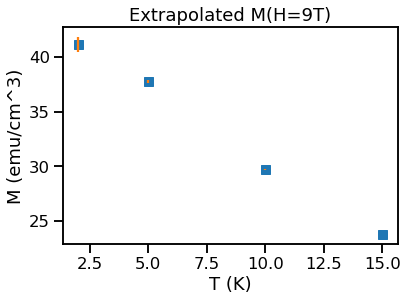

In [42]:
print("Approximate 9T Magnetizations from Fit:")
T_vals = []
Mag_vals = []
Mag_vals_unc = []
for T_val in brill_fit_results['T'].unique():
    df = brill_fit_results.query('T=={}'.format(T_val))
    M = df['Magnetization (emu/cm^3)'].values[0]
    M_min = df['Magnetization (emu/cm^3)_err_min'].values[0]
    M_max = df['Magnetization (emu/cm^3)_err_max'].values[0]
    unc = max(abs(M - M_min),abs(M - M_max))
    print("\n{}K, 9T:\nM_vol =".format(T_val),  np.round(M,2), '+/-', np.round(unc,2), "(emu/cm^3)")
    print('Min =', np.round(M_min,3), '(emu/cm^3)\nMax =', np.round(M_max, 3),'(emu/cm^3)')
    T_vals.append(T_val)
    Mag_vals.append(M)
    Mag_vals_unc.append(unc)
    
#T_vals = [2, 5, 10, 15]
#Mag_vals = [chosen_fit_results['Magnetization (emu/cm^3)'].values[i] for i in range(4)]
plt.plot(T_vals,Mag_vals, linestyle='None', marker='s')
plt.errorbar(x=T_vals, y=Mag_vals, yerr=Mag_vals_unc, linestyle='None')
plt.ylabel('M (emu/cm^3)')
plt.xlabel('T (K)')
plt.title('Extrapolated M(H=9T)')
#ax.set(ylabel=, xlabel=, title=)

## Calculate Extrapolated Data and Save


### Calculate Various Units

$\mu_b$ calculation : $M_{mu_b/f.u.} = \frac{M_g m_{mol}}{\mu_B N_a}10^{-3}$

where $M_g$ is the magnetization per gram, $m_{mol}$ is the molar mass, $\mu_B = 9.274*10^{-24} J/T$, $N_a=6.022*10^{23}mol^{-1}$, $1 emu = 10^{-3} J/T$


OR $1 emu = 1.078*10^{20} \mu_B$

In [43]:
chosen_fit_results = brill_fit_results  
# print(chosen_fit_results.columns)
chosen_fit_results['H (T)'] = chosen_fit_results['Magnetic Field (Oe)']/10000

chosen_fit_results['Moment (emu)'] = chosen_fit_results['Magnetization (emu/cm^3)']  *  volume_Brazil
chosen_fit_results['Moment (emu)_err_max'] = chosen_fit_results['Magnetization (emu/cm^3)_err_max']  * volume_Brazil 
chosen_fit_results['Moment (emu)_err_min'] = chosen_fit_results['Magnetization (emu/cm^3)_err_min']  * volume_Brazil 

chosen_fit_results['Magnetization (emu/g)'] = chosen_fit_results['Moment (emu)']  /sample_mass  
chosen_fit_results['Magnetization (emu/g)_err_max'] = chosen_fit_results['Moment (emu)_err_max']  /sample_mass  
chosen_fit_results['Magnetization (emu/g)_err_min'] = chosen_fit_results['Moment (emu)_err_min']  /sample_mass  

chosen_fit_results['Magnetization (emu/mol)'] = chosen_fit_results['Magnetization (emu/g)']  *  molar_mass
chosen_fit_results['Magnetization (emu/mol)_err_max'] = chosen_fit_results['Magnetization (emu/g)_err_max']  *  molar_mass
chosen_fit_results['Magnetization (emu/mol)_err_min'] = chosen_fit_results['Magnetization (emu/g)_err_min']  *  molar_mass

chosen_fit_results['Magnetization (muB/Yb)'] = chosen_fit_results['Magnetization (emu/mol)']  /  Na * 1.078*10**20
chosen_fit_results['Magnetization (muB/Yb)_err_max'] = chosen_fit_results['Magnetization (emu/mol)_err_max']  /  Na * 1.078*10**20
chosen_fit_results['Magnetization (muB/Yb)_err_min'] = chosen_fit_results['Magnetization (emu/mol)_err_min']  /  Na * 1.078*10**20


chosen_fit_results['Magnetic Flux Density (G)']  = chosen_fit_results['Magnetic Field (Oe)'] + (4*np.pi)*(1-D_factor_Brazil) * chosen_fit_results['Magnetization (emu/cm^3)']
chosen_fit_results['Magnetic Flux Density (G)_err_max']  = chosen_fit_results['Magnetic Field (Oe)'] + (4*np.pi)*(1-D_factor_Brazil) * chosen_fit_results['Magnetization (emu/cm^3)_err_max']
chosen_fit_results['Magnetic Flux Density (G)_err_min']  = chosen_fit_results['Magnetic Field (Oe)'] + (4*np.pi)*(1-D_factor_Brazil) * chosen_fit_results['Magnetization (emu/cm^3)_err_min']
chosen_fit_results['type'] = 'Extrap.'



### Concat with Real Data and Save

In [44]:

mag_data['Magnetization (emu/mol)'] = mag_data['Magnetization (emu/g)']  *  molar_mass
mag_data['Magnetization (muB/Yb)'] = mag_data['Magnetization (emu/mol)']  /  Na * 1.078*10**20

mag_data['H (T)'] = mag_data['Magnetic Field (Oe)'] / 10000
mag_data['type'] = 'Real'

extrapped_data = pd.concat([mag_data, chosen_fit_results]).fillna(0)
extrapped_data['D_brazil'] = D_factor_Brazil

extrapped_data.to_csv('M_of_H_Brazil_extrapolated.csv', sep=',')
brill_fit_results.to_csv('final_parameters_M_of_H_brill_extrap.csv', sep=',')

# with open('final_parameters_M_of_H_brill_extrap.csv', 'r+') as f:
#         content = f.read()
#         f.seek(0, 0)
#         f.write('Fitted function:, M=M0 B_j(A*g_j_Yb*mu_B*J* B(H)/ (kb T)) +C*H, B = H+4*np.pi*(1-D)*M' + '\n' + content)
        
# with open('M_of_H_Brazil_extrapolated.csv', 'r+') as f:
#         content = f.read()
#         f.seek(0, 0)
#         f.write('Fitted function:, M=M0 B_j(A*g_j_Yb*mu_B*J* B(H)/ (kb T)) +C*H, B = H+4*np.pi*(1-D)*M' + '\n' + content)
              


# Cheb Fit $\rho_{xx}(H)$ ACTRot12

What about what's loaded in the first cell???

### Define Sample Specific Parameters

In [45]:
'''
    ACTPuck2, no bus but we can find a % change between the two total magnetic
    field values: 6K, 8K, 12K, 20K. These may be hall resistivities, though.
    
    ResPuck2, has 2K sweep of the field on bridge 3, may conflict wth ACTRot1??
    
    ACTRot1, has 5K angular measurements, and one RvH run at 2K from 0.1T to 9T.
    
    GOT DATA FROM ACTROT12!!! ty toujours Michael. File path for 10K:
    OneDrive - Universite de Montreal/James Fraser - Gr - LaboBianchi/Digital Lab Book/1 Analysis Scripts and Readings/Script Analyses/YbPdBi, AMRO Analyses/Dresden Data/ACTRot12, parallel, Dresden Analysis/Local Data/ACTRot12_Dres2_10K_MR.csv
'''

# ACTROT12, but since it has been processed, no scaling
L = 0.0786   # cm, NOT THE LENGTH between the voltage wires
W = 0.09172  # cm
H = 0.08020  # cm ||B

a = L/2.0
b = W/2.0
c = H/2.0 # ||B

volume_MR = L*W*H
D_factor_MR = DFactor(a, b, c)
print("Sanity check, 1 =", DFactor(a,b,c)+DFactor(b,c,a)+DFactor(c, a, b))

# Change to the folder where the processed data is stored.
cur_dir = os.getcwd()



Sanity check, 1 = 0.9999999999999994


### Load MR Data from ACTRot12, and Plot

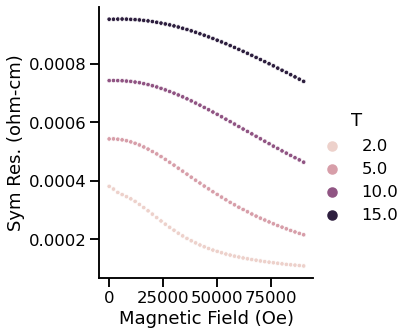

In [46]:
MR_directory = r''
filename= 'YbPdBi, JF039, ACTRot12 ACTRot13 Symmetrized MR.csv'  
T_vals = [2, 5, 10, 15]

MR_df = pd.read_csv(os.path.join(MR_directory, filename), delimiter=',')# skiprows=25)
avg_MR_df = MR_df.query('T in @T_vals & puck_id == "actrot12" & `Sample Position (deg)` == 0')

sns.relplot(x='Magnetic Field (Oe)', y='Sym Res. (ohm-cm)',
                data = avg_MR_df, linestyle='None', marker='.', hue = 'T')


### Use fsolve Function and Fit Parameters to Guess the Magnetization

False


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_30796\4274439308.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  coth1 = 1/np.tanh(J1*x)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_30796\4274439308.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  coth2 = 1/np.tanh(J2*x)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_30796\4274439308.py:34: RuntimeWarning: invalid value encountered in double_scalars
  Bj= J1*coth1 - J2*coth2
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_30796\2005941640.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

<AxesSubplot:xlabel='Magnetization (emu/cm^3)', ylabel='Sym Res. (mohm-cm)'>

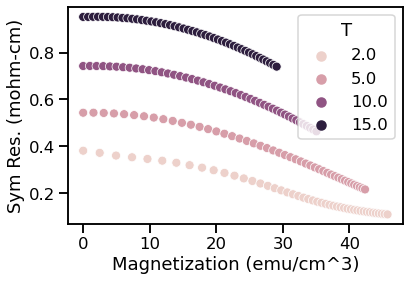

In [47]:
D = D_factor_MR
MR_mag = []
for index, row in avg_MR_df.merge(lmfit_mag_results_lin_L, on='T').iterrows():
    H =row['Magnetic Field (Oe)']

    T = row['Temperature (K)']
    J = row['J']
    C =row['C']
    n =row['n']
    
    # H, D, T, J, C, n)
    mag = Solve_for_M_w_L(H, D, T, J, C, n)
    MR_mag.append(mag)

avg_MR_df['Magnetization (emu/cm^3)']  = MR_mag
print(avg_MR_df['Magnetization (emu/cm^3)'].isna().any())

sns.scatterplot(x='Magnetization (emu/cm^3)', #'Magnetic Flux Density (G)',
                y='Sym Res. (mohm-cm)', data=avg_MR_df, hue='T')

### Calculate MR(B)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_30796\2909648821.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  B_MR_df['Magnetic Flux Density (G)']  = B_df


MR demagnetization factor:  0.3455518966470444


<AxesSubplot:xlabel='Magnetization (emu/cm^3)', ylabel='Sym Res. (mohm-cm)'>

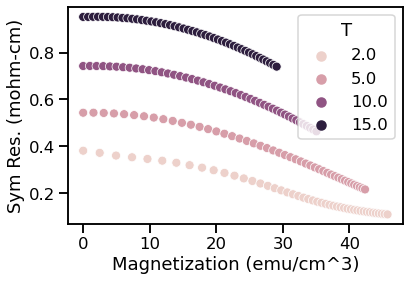

In [48]:

B_MR_df = avg_MR_df
print("MR demagnetization factor: ", D_factor_MR)
B_df = pd.DataFrame()

for T in [2, 5, 10, 15]:
    temp_df = pd.DataFrame()
    q_df = avg_MR_df.query('T == {}'.format(T))
    
    M_vol = q_df['Magnetization (emu/cm^3)'] #chebval( q_df['Abs. Magnetic Field (Oe)'], MvH_cheb_coeffs[T])
    
    temp_df['Magnetic Flux Density (G)'] = q_df['Magnetic Field (Oe)'] + (4*np.pi)*(1-D_factor_MR) * M_vol
   
    #B = H + 4pi(1-D) M_vol(H)
    
    B_df = pd.concat([B_df, temp_df])
    

B_MR_df['Magnetic Flux Density (G)']  = B_df

sns.scatterplot(x='Magnetization (emu/cm^3)', #'Magnetic Flux Density (G)',
                y='Sym Res. (mohm-cm)', data=B_MR_df, hue='T')

## Is there an M^2 dependence on the MR?

Yosida 1957 derived that the MR caused by the s-d interaction is proportional to the square of the magnetization:

$  \frac{\Delta R}{R_0} = -0.61 \frac{\langle m\rangle^2}{S^2}$

Would be useful to fit these with a line and see if we get $0.61/S^2$

In [49]:
# min_R_vals = B_MR_df.query('`Magnetic Field (Oe)` == 0')[['T', 'Sym Res. (ohm-cm)']]
# B_MR_df = B_MR_df.merge(min_R_vals, on=['T'], suffixes = ["", "_0"])

B_MR_df['M^2'] = B_MR_df['Magnetization (emu/cm^3)'].pow(2)
B_MR_df['del R'] = B_MR_df['Sym Res. (ohm-cm)'] - B_MR_df['Sym Res. (ohm-cm)_0']
B_MR_df['del R/R0'] = (B_MR_df['Sym Res. (ohm-cm)'] - B_MR_df['Sym Res. (ohm-cm)_0'])/B_MR_df['Sym Res. (ohm-cm)_0']
B_MR_df['del R/R0 (%)'] = B_MR_df['del R/R0'] * 100



C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_30796\3872554519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  B_MR_df['M^2'] = B_MR_df['Magnetization (emu/cm^3)'].pow(2)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_30796\3872554519.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  B_MR_df['del R'] = B_MR_df['Sym Res. (ohm-cm)'] - B_MR_df['Sym Res. (ohm-cm)_0']
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_30796\3872554519.py:6: SettingWithCopyWarning: 
A val

In [50]:
print(B_MR_df.columns)

Index(['Unnamed: 0', 'Magnetic Field (Oe)', 'H (T)', 'Sym Res. (ohm-cm)',
       'Res. ch2 (ohm)', 'Temperature (K)', 'Sym Res. (ohm)',
       'Sym Res. (mohm-cm)', 'H^2 (T^2)', 'Cond (1/ohm)', 'Cond (1/ohm-cm)',
       'Cond (1/mohm-cm)', 'Sample Position (deg)', 'T', 'puck_id',
       'Sym Res. (ohm-cm)_0', 'del R', 'del R/R0', 'del R/R0 (%)',
       'Cond (1/ohm-cm)_0', 'del C', 'del C/C0', 'del C/C0 (%)',
       'Magnetization (emu/cm^3)', 'Magnetic Flux Density (G)', 'M^2'],
      dtype='object')


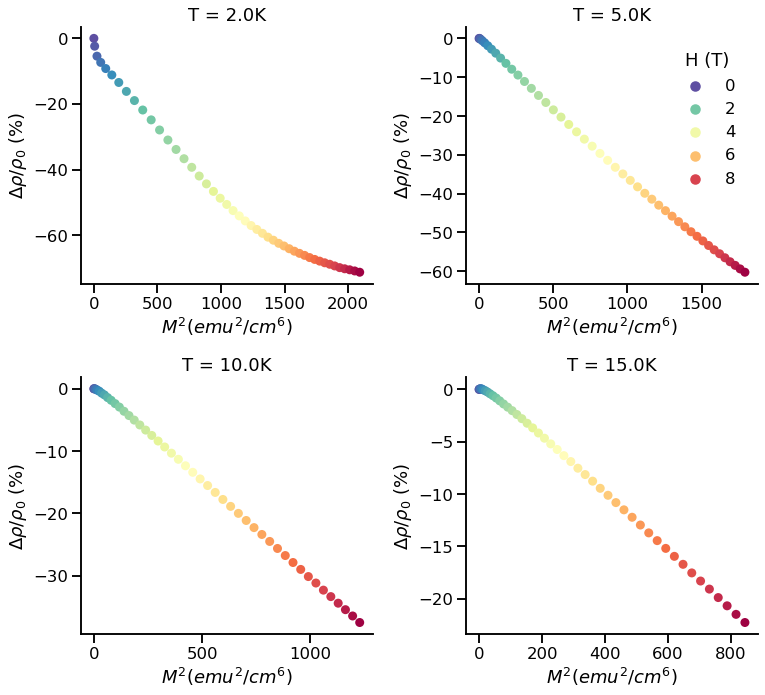

In [51]:
sns.set_context('talk')
g = sns.relplot(x=  'M^2',  # 'Magnetization (emu/cm^3)', #
                 y='del R/R0 (%)', # 'Res. ch2 (ohm-cm)', # 
                 col='T', col_wrap=2,
                 linewidth=0,
                 hue='H (T)', hue_order=B_MR_df['H (T)'].unique(),#'Magnetization (Oe)',
                 palette = sns.color_palette("Spectral_r", as_cmap=True), #sns.color_palette('colorblind', len(B_MR_df['T'].unique())),
                 facet_kws={'sharex':False,'sharey':False},
                 data=B_MR_df.sort_values('H (T)', ascending=True))
g.set(ylabel=r'$\Delta\rho/\rho_0$ (%)', xlabel=r'$M^2 (emu^2/cm^6)$')#, title='YbPdBi, MR(H^2)')
#g.set(ylabel=r'$\Delta\rho/\rho$ (%)', xlabel=r'$M (emu/cm^3)$', title='YbPdBi, MR(H^2)')
g._legend.set_bbox_to_anchor([0.95, 0.8]) 
# FlipLegend(ax, title='T (K)')
g.set_titles('T = {col_name}K')

plt.tight_layout()
plt.savefig('YbPdBi, yosida Linearization of MR by Msquared.pdf', dpi=300, transparent=False, bbox_inches='tight')

## Double check $\rho(M)$ by curve fitting the function from Madjumdar and Littlewood
Equation is for metallic ferromagnets, but should work with a magnetized sample?

Will need to use lmfit results and also another lmfit fitting algorithm

In [52]:
def majumdar_func(M_of_H, rho_0, M_0, A, exp):
    ## The actual paper seems to imply that there is no -1 term 
    # but! \Delta \rho / \rho_mean = (rho_H -\rho_mean)/\rho_mean , so it's ok
    rho_of_H = (1-A*(M_of_H/M_0)**2)*rho_0
    return rho_of_H

In [53]:
majumdar_fit_result_objs = []
majumdar_fit_params = pd.DataFrame()
majum_func_dict = {}

for T in B_MR_df['T'].unique():

    q = 'T=={}'.format(T)
    fit_df = B_MR_df.query(q)
    mag_fit_params = lmfit_mag_results_lin_L.query(q)

    # Extract experimental data
    rho_vals = fit_df['Sym Res. (mohm-cm)'].values
    M_vals = fit_df['Magnetization (emu/cm^3)'].values
    
    #H_vals = fit_df[x_label].values
    #T_vals = fit_df['Temperature (K)'].values
    rho_0 = max(rho_vals)
    M0 = mag_fit_params['M0'].values[0]
    
    ###### FITTING #######
    # Create the Model, then declare independant variables and fit parameters
    gmodel = lm.Model(func = majumdar_func, independent_vars = ['M_of_H'], param_names=['M_0', 'rho_0', 'A', 'exp'])
    
    gmodel.set_param_hint('M_0', vary=False, value = M0)
    gmodel.set_param_hint('rho_0', vary=False, value = rho_0)
    
    gmodel.set_param_hint('A', vary=True, value = 5, min=0)
    gmodel.set_param_hint('exp', vary=True, value = 2, min=0)


    # Perform the fit on the Model
    result = gmodel.fit(data = rho_vals, M_of_H=M_vals)#, M=M_vals, D=D, T=T_vals)#, method = "least_squares")
    majumdar_fit_result_objs.append(result)
    
    fit_params_dict = result.best_values
    fit_covar_matrix = result.covar

    params_df = pd.DataFrame(fit_params_dict, index=[0])
    #params_df['exp err'] = fit_covar_matrix[0][0]**0.5
    #params_df['A err'] = fit_covar_matrix[1][1]**0.5
    params_df['T'] = float(T)

    # Store params in a dataframe
    majumdar_fit_params = pd.concat([majumdar_fit_params, params_df])

    # Store function in dict to be called later with different H NOTE: May not work since magnetization is on both sides...
    majum_func_dict[str(T)] = result.eval
    # print('\n'+str(T)+ ' params dict:\n',fit_params_dict)
    #print(str(T)+' covar:\n', fit_covar_matrix)
print(majumdar_fit_params)

         M_0     rho_0         A  exp     T
0  27.950755  0.381132  0.315722  2.0   2.0
0  43.044828  0.543368  0.644970  2.0   5.0
0  53.330390  0.742736  0.860560  2.0  10.0
0  56.747540  0.952719  0.827070  2.0  15.0


### Plot Majumdar $\rho_{MR}(M)$ Fits

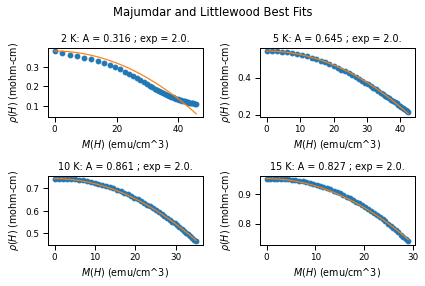

In [54]:
fig = plt.figure()
i=1
temp_names = majumdar_fit_params['T'].values
sns.set_context('paper')
for i_plot, result in enumerate(majumdar_fit_result_objs):
    
    fit_A = result.best_values['A']
    fit_exp = result.best_values['exp']
    T_val =  temp_names[i_plot]
    

    
    ax = fig.add_subplot(2, 2, i_plot+1)
    
    T_label = str(int(T_val))+' K'
    plot_title = '{}: A = {} ; exp = {}.'.format(T_label, round(fit_A,3), round(fit_exp,1))
    result.plot_fit(title=plot_title, ax=ax)

 
    ax.set_ylabel(r'$\rho(H)$ (mohm-cm)')
    ax.set_xlabel('$M(H)$ (emu/cm^3)')
    ax.legend().remove()

fig.suptitle('Majumdar and Littlewood Best Fits')
plt.tight_layout()

## Interpolate MR(B) Data with Chebyshev Polynomials

In [55]:

cheb_degrees = 15
x_label = 'Magnetic Flux Density (G)'
y_label = 'Sym Res. (ohm-cm)'

T_vals = [2, 5, 10, 15]

RvB_cheb_coeffs = {}
RvB_cheb_residuals = {}

for T in T_vals:
    try:
        x_data = B_MR_df.query('T == {}'.format(T))[x_label]
        y_data = B_MR_df.query('T == {}'.format(T))[y_label]

        coeffs = chebfit(x_data, y_data, deg=cheb_degrees)
        RvB_cheb_coeffs[T] = coeffs

        residuals = 100.0*(chebval(x_data, coeffs) - y_data) / y_data
        RvB_cheb_residuals[T] = residuals
    except Exception as e:
        print(T)
        print(x_data)
        print(y_data)
        print(e)
        break

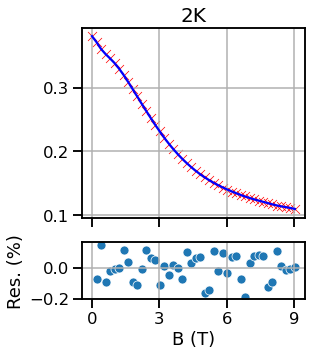

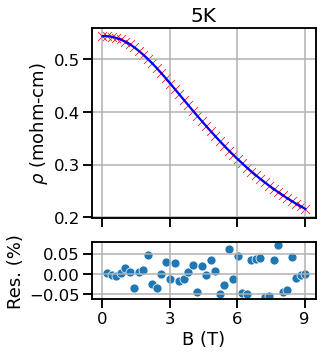

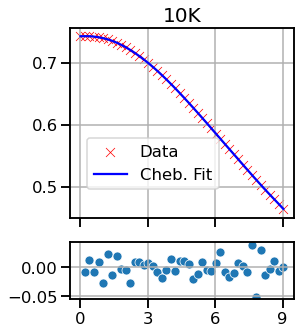

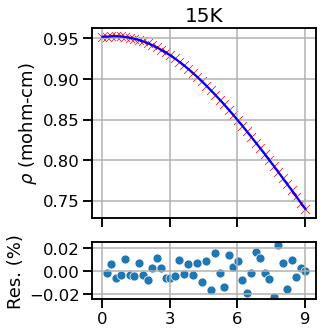

In [56]:

cheb_degrees = 15
x_label = 'Magnetic Flux Density (G)'
y_label = 'Sym Res. (ohm-cm)'

temps = [2, 5, 10, 15]
#fig, axs = plt.subplots(2,4, sharex=True)
# fig, axs = plt.subplots(2, 4, sharex=True, sharey=False, gridspec_kw={'height_ratios': [1, 0.5]})

H_ticks = np.linspace(0, 9, 4)


fig.set_size_inches(15,5)

i=0
while i < len(temps):
    T = temps[i]

    sns.set_context('talk')
    fig, axs = plt.subplots(2,1, sharex=True, sharey=False, gridspec_kw={'height_ratios': [1, 0.3]})
    fig.set_size_inches(4,5)
    
    fit_ax = axs[0]#[i]
    res_ax = axs[1]#[i]
       
    T = temps[i%len(temps)]
    
    plot_df = B_MR_df.query('T == {}'.format(T))

    plot_x = plot_df[x_label].values/10000 
    plot_y = plot_df[y_label].values
                     

    # Plot resistivity
    # Data
    sns.scatterplot(x= plot_x, y=plot_y*1000, marker='x', ax=fit_ax, color='r', label='Data')
    # PLot Cheb
    sns.lineplot(x=plot_x, y = chebval(plot_x*10000, RvB_cheb_coeffs[T])*1000, ax=fit_ax, color='b', label='Cheb. Fit')
    # Residuals
    sns.scatterplot(x=plot_x[1:], y=RvB_cheb_residuals[T][1:], ax=res_ax)


        
    # Formattingax.set_xticklabels(xticklabels,  ha="right")

    res_ax.set_xticks(H_ticks)#, rotation = 45,  ha="right")
    fit_ax.set_ylabel(r'$\rho$ (mohm-cm)')
    res_ax.set_ylabel('Res. (%)')
    
    res_ax.set_xlabel(None)
    res_ax.set_xlabel(r'B (T)')
    # res_ax.set_ylabel(r'$\rho$ (mohm-cm)')
    
    res_ax.grid()
    fit_ax.grid()
    fit_ax.legend(loc=(0.075, 0.15))
    
    plot_title = str(T) 
    fit_ax.set_title(plot_title+"K", size=20)
    
    # Delete repeated axes labels
    # if i >0:
    #     fit_ax.set_ylabel(None)
    #     res_ax.set_ylabel(None)
   # Modify labels and legends for visual clarity
    if T == 2:
        fit_ax.legend().remove()
        fit_ax.set_ylabel(None)

    elif T == 5:
        fit_ax.legend().remove()
        res_ax.set_ylabel('Res. (%)')
    elif T == 10:
        fit_ax.set_xlabel(None)
        res_ax.set_xlabel(None)
        
        fit_ax.set_ylabel(None)
        res_ax.set_ylabel(None)
        

    elif T == 15:
        fit_ax.legend().remove()
        fit_ax.set_xlabel(None)
        res_ax.set_xlabel(None)
        
        res_ax.set_ylabel('Res. (%)')       
        
    # if i < 3: 
    #     fit_ax.legend().remove()
    i+=1
    fig.savefig('MR Cheb Fits {}K.pdf'.format(T), dpi=300, transparent=False, bbox_inches='tight')

scale_factor = 0.9
# fig.set_size_inches(18*scale_factor,7*scale_factor)
# plt.subplots_adjust(hspace=0.12, wspace=0.39)
plt.show()


# Calculate Demag Amplitudes For all ACTRot11 and ACTRot13's

## Calculate $M_{vol}$ and B for AMRO Data 

### Load All AMRO Datasets and Select $0^\circ$ and $90^\circ$

In [57]:
print(amro_df.columns)

Index(['Temperature (K)', 'Sample Position (deg)', 'Res. ch2 (ohm-cm)',
       'Mean Res. (ohm-cm)', 'ACT', 'T', 'H', 'geo', 'L (cm)', 'W (cm)',
       'H (cm)', 'Res. ch2 (mohm-cm)', 'Res. ch2 (uohm-cm)',
       'Sample Position (rads)', 'Res. ch2 (ohm-cm)_min', '0deg Res (ohm-cm)',
       'del R 0deg', 'R/R0 0deg', 'del R/R0 0deg', 'del R/R0 0deg (%)',
       'del R mean', 'del R/R0 mean', 'R/R0 mean', 'del R/R0 mean (%)',
       'delR (mohm-cm) mean', 'delR (uohm-cm) mean'],
      dtype='object')


In [58]:
# Res = chebval(plot_x, RvB_cheb_coeffs[T])

max_positions = [0.1, 90.1, 180.1, 270.1, 360.1]
min_positions = [-0.1, 89.9, 179.9, 269.9, 359.9]

deg_label = 'Sample Position (deg)'
res_label = 'Res. ch2 (ohm-cm)'
geo_label = 'geo'

# Select only the orientations parallel or perpendicular to the field
amro_df = pd.read_csv('AMRO_combined_data.csv', sep=',', index_col='Unnamed: 0')#.query('T >=2 & T<20 ')
amro_df.drop('Abs. Magnetic Field (Oe)', inplace=True, axis=1)
# Get mean of each AMRO dataset, NOTE: probably don't need this, want mean of the expected MR data...
#amro_means = amro_df.groupby(['ACT', 'T', 'H', 'geo']).mean()[['Res. ch2 (ohm-cm)']].reset_index().rename(columns = {'Res. ch2 (ohm-cm)':'Mean Res. (ohm-cm)'})

# Prepare query string to get the desired sample orientations
deg_q = ''
for deg_min, deg_max in zip(min_positions, max_positions):
    deg_q+= '(`{}` > {} & `{}` < {})'.format(deg_label, deg_min, deg_label, deg_max)
    deg_q+= "|"
deg_q = deg_q[:-1]

# Query for just the desired orientations, and round for an easier life
amro_angles_df = amro_df.query(deg_q)
amro_angles_df[deg_label] = amro_angles_df[deg_label].round()

print(amro_angles_df[deg_label].unique())
amro_angles_df.query('ACT=="ACTRot12"').head(5)

[  0.  90. 180. 270. 360.]


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_30796\1170526307.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amro_angles_df[deg_label] = amro_angles_df[deg_label].round()


,Temperature (K),Sample Position (deg),Res. ch2 (ohm-cm),Mean Res. (ohm-cm),ACT,T,H,geo,L (cm),W (cm),...,del R 0deg,R/R0 0deg,del R/R0 0deg,del R/R0 0deg (%),del R mean,del R/R0 mean,R/R0 mean,del R/R0 mean (%),delR (mohm-cm) mean,delR (uohm-cm) mean
5872,9.999777,90.0,0.000742,0.000742,ACTRot12,10.0,0.5,para,0.0786,0.09172,...,-4.213628e-07,0.999432,-0.000568,-0.056778,-1.689431e-07,-0.000228,0.999772,-0.022773,-0.000169,-0.168943
5962,10.000210,180.0,0.000742,0.000742,ACTRot12,10.0,0.5,para,0.0786,0.09172,...,-1.500449e-08,0.999980,-0.000020,-0.002022,2.374152e-07,0.000320,1.000320,0.032002,0.000237,0.237415
6052,10.000373,270.0,0.000742,0.000742,ACTRot12,10.0,0.5,para,0.0786,0.09172,...,-4.576860e-07,0.999383,-0.000617,-0.061672,-2.052664e-07,-0.000277,0.999723,-0.027669,-0.000205,-0.205266
6142,9.999823,360.0,0.000742,0.000742,ACTRot12,10.0,0.5,para,0.0786,0.09172,...,-2.071986e-07,0.999721,-0.000279,-0.027920,4.522107e-08,0.000061,1.000061,0.006096,0.000045,0.045221
6143,10.001484,360.0,0.000698,0.000698,ACTRot12,10.0,3.0,para,0.0786,0.09172,...,-3.037440e-07,0.999565,-0.000435,-0.043513,1.302815e-07,0.000187,1.000187,0.018675,0.000130,0.130282


In [59]:
print(amro_angles_df['ACT'].unique())

['ACTRot11' 'ACTRot12' 'ACTRot13' 'ACTRot14']


### Join AMRO orientation data with relevant Brillouin fit parameters

In [60]:
# Left join with relevant fit parameters of Brillouin fits
amro_angles_with_fit_params_df = amro_angles_df.merge(lmfit_mag_results_lin_L, on='T')

print('Initial Shape: # Rows=', amro_angles_df.shape[0],', # Columns =',amro_angles_df.shape[1])
print('Joined Shape: # Rows=', amro_angles_with_fit_params_df.shape[0],', # Columns =',amro_angles_with_fit_params_df.shape[1])
print('\nChanged due to a reduction in T values.')
print('Initial unique T values:', amro_angles_df['T'].unique())
print('Joined unique T values:', amro_angles_with_fit_params_df['T'].unique())

Initial Shape: # Rows= 414 , # Columns = 26
Joined Shape: # Rows= 299 , # Columns = 39

Changed due to a reduction in T values.
Initial unique T values: [10.  15.   1.9  2.  30.   5.  20.  60. ]
Joined unique T values: [10. 15.  2.  5.]


### Calulate D Factors, Solve for $M_{vol}$, and determine B Fields

In [64]:
amro_angles_with_fit_params_df.columns

Index(['Temperature (K)', 'Sample Position (deg)', 'Res. ch2 (ohm-cm)',
       'Mean Res. (ohm-cm)', 'ACT', 'T', 'H', 'geo', 'L (cm)', 'W (cm)',
       'H (cm)', 'Res. ch2 (mohm-cm)', 'Res. ch2 (uohm-cm)',
       'Sample Position (rads)', 'Res. ch2 (ohm-cm)_min', '0deg Res (ohm-cm)',
       'del R 0deg', 'R/R0 0deg', 'del R/R0 0deg', 'del R/R0 0deg (%)',
       'del R mean', 'del R/R0 mean', 'R/R0 mean', 'del R/R0 mean (%)',
       'delR (mohm-cm) mean', 'delR (uohm-cm) mean', 'J', 'J err', 'C',
       'C err', 'n', 'n err', 'D', 'M0', 'M0 err', 'C (T)', 'C (T) err',
       'n (mols)', 'n (mols) err'],
      dtype='object')

In [65]:
# Can be lazy and just calculate D multiple times and differentiate by column name
# D0 can be calculated at the same time for both geometries since the first two parameters of DFactor
# NOTE:
# Third entry to DFactor must be parallel to the applied magnetic field
print('Deg zero test:', DFactor(1,2,3), DFactor(2,1,3))
D_list = []
B_list = []
AMRO_mag = []

amro_angles_mag_B_df = amro_angles_with_fit_params_df.copy()

for index, row in amro_angles_with_fit_params_df.iterrows():
    
    if row[deg_label] in [0, 180, 360]:
        
            D = DFactor(row['L (cm)']/2.0, row['W (cm)']/2.0, row['H (cm)']/2.0)
            H =row['H']

            T = row['Temperature (K)']
            J = row['J']
            C =row['C']
            n =row['n']
            M = Solve_for_M_w_L(H, D, T, J, C, n)
            
            
            B = row['H'] + (4*np.pi) * (1-D) * M# chebval( row['Abs. Magnetic Field (Oe)'], MvH_cheb_coeffs[T])
            
            D_list.append(D)
            B_list.append(B)
            AMRO_mag.append(M)
    elif row[deg_label] in [90, 270]:  
        if row[geo_label] == 'para':


            D = DFactor( row['H (cm)']/2.0,row['W (cm)']/2.0, row['L (cm)']/2.0)
            H =row['H']

            T = row['Temperature (K)']
            J = row['J']
            C =row['C']
            n =row['n']
            M = Solve_for_M_w_L(H, D, T, J, C, n)
            
            
            #print(row['Abs. Magnetic Field (Oe)']+(4*np.pi)*(1-D) * chebval( row['Abs. Magnetic Field (Oe)'], MvH_cheb_coeffs[T]))
            
            B = row['H'] + (4*np.pi)*(1-D) * M#chebval( row['Abs. Magnetic Field (Oe)'], MvH_cheb_coeffs[T])

            D_list.append(D)
            B_list.append(B)
            AMRO_mag.append(M)

        
        elif row[geo_label] == 'perp':
            if row[deg_label] in [90, 270]:
                D = DFactor(row['L (cm)']/2.0, row['H (cm)']/2.0, row['W (cm)']/2.0)

                H =row['H']

                T = row['Temperature (K)']
                J = row['J']
                C =row['C']
                n =row['n']
                M = Solve_for_M_w_L(H, D, T, J, C, n)
            
                B = row['H'] + (4*np.pi)*(1-D) * M#chebval( row['Abs. Magnetic Field (Oe)'], MvH_cheb_coeffs[T])

                D_list.append(D)
                B_list.append(B)
                AMRO_mag.append(M)
        else:
            print('Weird Row')
            print(row)
            continue        


amro_angles_mag_B_df['D'] = np.array(D_list) 
amro_angles_mag_B_df['Magnetic Flux Density (G)']  = B_list   
amro_angles_mag_B_df['Magnetization (emu/cm^3)'] = AMRO_mag

amro_angles_mag_B_df.head(5)

Deg zero test: 0.18281797804039265 0.18281797804039293


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


,Temperature (K),Sample Position (deg),Res. ch2 (ohm-cm),Mean Res. (ohm-cm),ACT,T,H,geo,L (cm),W (cm),...,n err,D,M0,M0 err,C (T),C (T) err,n (mols),n (mols) err,Magnetic Flux Density (G),Magnetization (emu/cm^3)
0,9.996684,0.0,0.000395,0.000395,ACTRot11,10.0,0.5,perp,0.2107,0.09315,...,0.0,0.424684,53.33039,0.021079,0.0,0.0,0.003189,0.0,0.501818,0.000251
1,10.000913,90.0,0.000395,0.000395,ACTRot11,10.0,0.5,perp,0.2107,0.09315,...,0.0,0.400857,53.33039,0.021079,0.0,0.0,0.003189,0.0,0.501893,0.000251
2,10.000187,180.0,0.000395,0.000395,ACTRot11,10.0,0.5,perp,0.2107,0.09315,...,0.0,0.424684,53.33039,0.021079,0.0,0.0,0.003189,0.0,0.501817,0.000251
3,10.000099,270.0,0.000395,0.000395,ACTRot11,10.0,0.5,perp,0.2107,0.09315,...,0.0,0.400857,53.33039,0.021079,0.0,0.0,0.003189,0.0,0.501893,0.000251
4,10.000033,360.0,0.000395,0.000395,ACTRot11,10.0,0.5,perp,0.2107,0.09315,...,0.0,0.424684,53.33039,0.021079,0.0,0.0,0.003189,0.0,0.501817,0.000251


### D-Factor Ratios

In [66]:
for num in ['11', '12', '13', '14']:
    pr_df = amro_angles_mag_B_df.query('ACT == "{}"'.format("ACTRot"+num))
    # pr_df = pr_df.query('`Sample Position (deg)` in (0, 90)')[['Sample Position (deg)', 'D']]
    pr_df = pr_df[['Sample Position (deg)', 'D']]
    print(num)
    print(pr_df.head(2))
    print('Ratio:', pr_df['D'].iloc[1]/ pr_df['D'].iloc[0])
    print()

11
   Sample Position (deg)         D
0                    0.0  0.424684
1                   90.0  0.400857
Ratio: 0.9438944584464732

12
    Sample Position (deg)         D
20                   90.0  0.352532
21                  180.0  0.345552
Ratio: 0.9801994022840053

13
    Sample Position (deg)         D
36                    0.0  0.333158
37                   90.0  0.413281
Ratio: 1.2404978286080393

14
    Sample Position (deg)         D
56                    0.0  0.428773
57                   90.0  0.431242
Ratio: 1.0057577125790136



### Plot to Check Magnetization Approximation

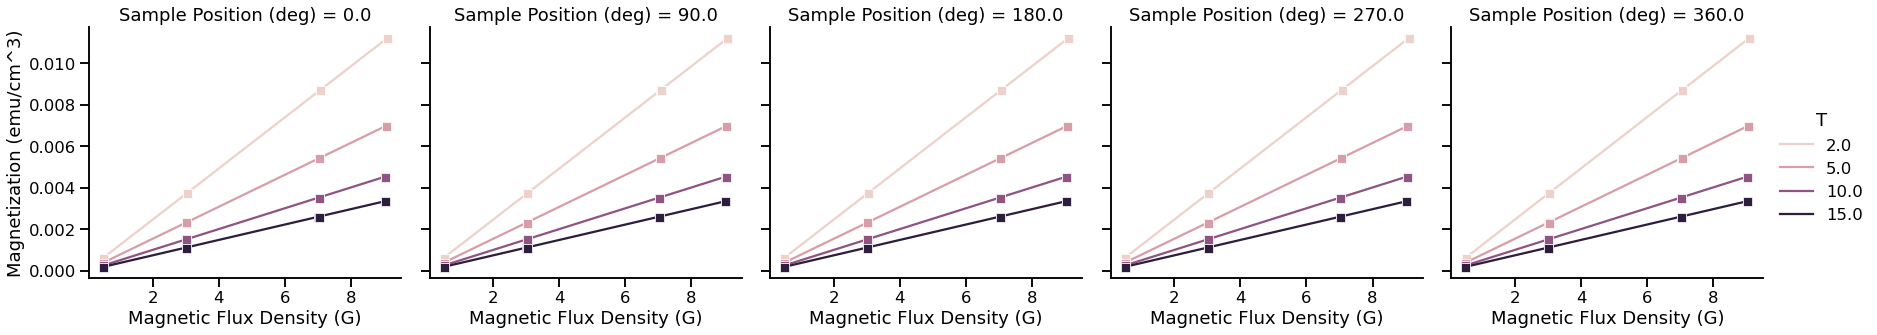

<AxesSubplot:xlabel='Magnetic Flux Density (G)', ylabel='Magnetization (emu/cm^3)'>

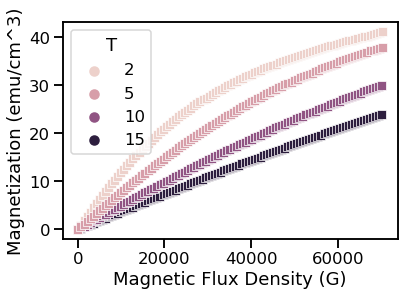

In [67]:
x_label = 'Magnetic Flux Density (G)'
y_label = 'Magnetization (emu/cm^3)' 

#q = '(`{}`==0 | `{}`==90)'.format(deg_label, deg_label)
plot_df = amro_angles_mag_B_df#.query(q)#.sort_values(['T', 'H', x_label])

sns.relplot(x=x_label, y= y_label, hue='T', kind='line',marker='s', col = deg_label, data=plot_df)
plt.show()
sns.scatterplot(x=x_label, y= y_label, marker='s', hue='T', data=mag_data.reset_index(drop=True))



### Plot Resistivity to Check Field Conversion

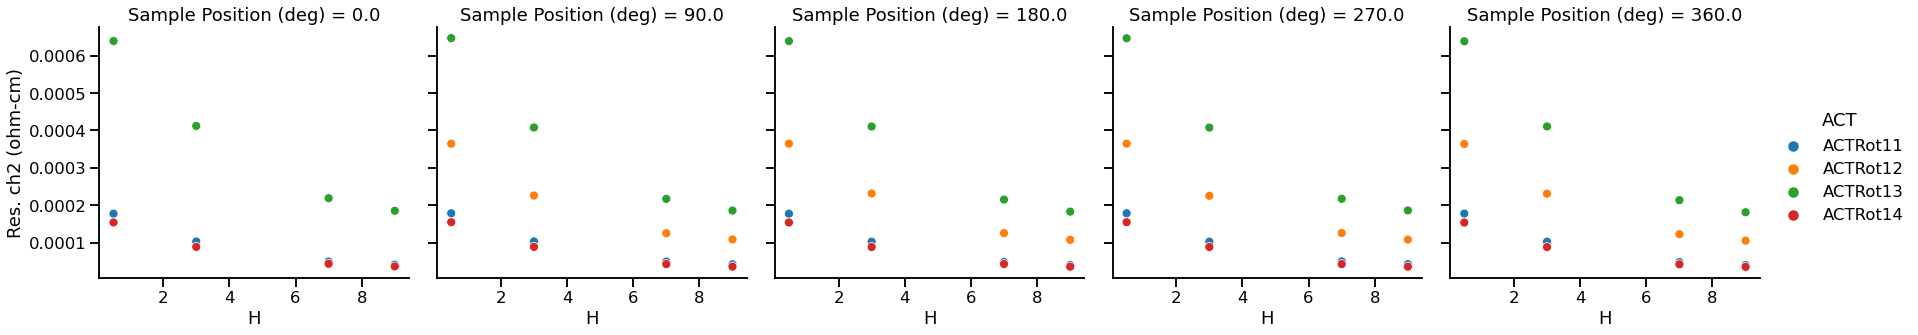

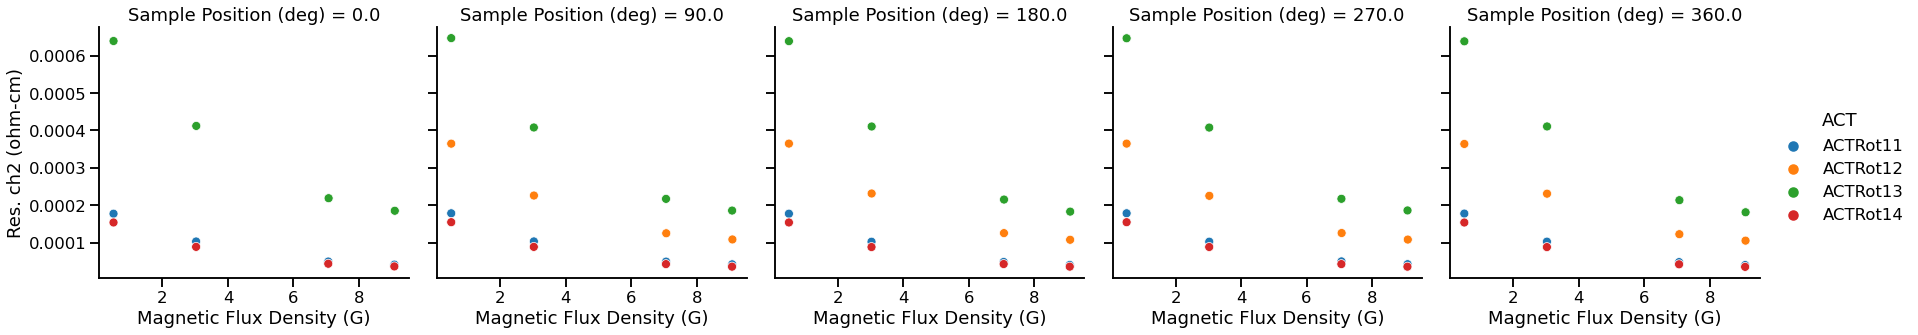

In [69]:
sns.set_context('talk')

#sns.relplot(x=deg_label, y= res_label, col='T', hue = 'Magnetic Flux Density (G)', data=amro_df)
plot_T = 2
plot_df = amro_angles_mag_B_df.query('T=={}'.format(plot_T))
sns.relplot(x='H', # 'Abs. Magnetic Field (Oe)', 
            y= res_label, hue='ACT', col=deg_label, data=plot_df)
sns.relplot(x='Magnetic Flux Density (G)', 
            y= res_label, hue='ACT', col=deg_label, data=plot_df)


## Use MR Chebyshev to find $a_{dem}$ for each ACTRot# at each T and B

Will have 2-fold Symmetry from square-ness of each sample's cross-section.

Could be a problem if we later find that the mechanical offset is significant, and that the resistivity at the desired angles changes a lot between these angles, ...

### Get expected Magnetoresistivities from RvB Chebyshev fit

In [70]:
dem_res_list = []
meaned_dem_res_list = []
for index, row in amro_angles_mag_B_df.iterrows():
    res = chebval(row['Magnetic Flux Density (G)'], RvB_cheb_coeffs[int(row['T'])])

    dem_res_list.append(res)


amro_angles_mag_B_df['Cheb. MR Res.'] = dem_res_list


### Plot a_dem vs sample position, for both Geometries

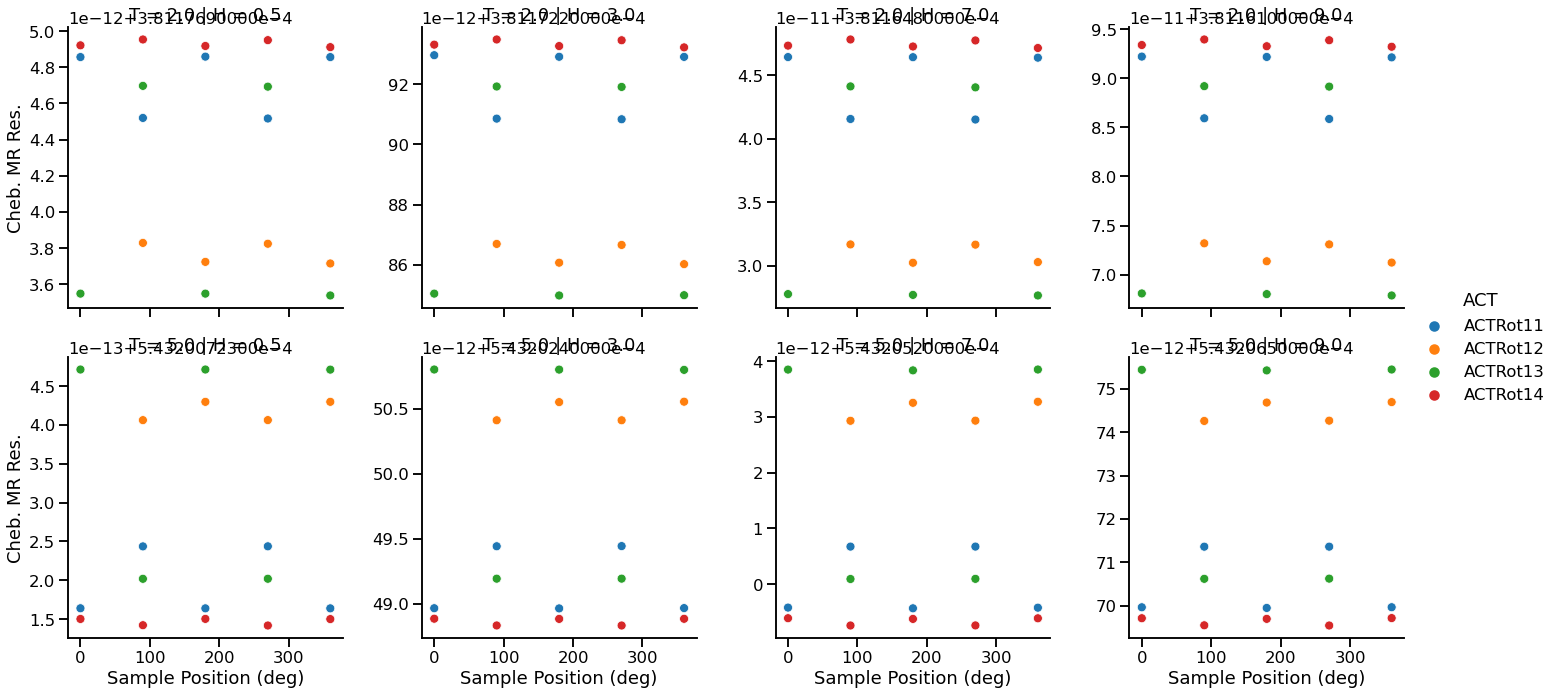

In [71]:
# Take average of abs values of, (90-0), (180-90), (180-0) (270-180), (360-270)
sns.set_context('talk')
plot_df = amro_angles_mag_B_df.query('T<10')
a = sns.relplot(x=deg_label, y='Cheb. MR Res.' , data = plot_df, col='H', row ='T', hue ='ACT', facet_kws={'sharey': False})



Since they're all gonna the be the same, may as well just take half the difference between 0 and 90

### Obtain the Demag Amplitudes by taking half the difference between 0 and 90, and dividing by their mean value

In [72]:
# For all take Half the Difference Between Valus at 0 and 90
amro_angles_mag_B_df['Delta MR Res.'] = amro_angles_mag_B_df['Cheb. MR Res.']-amro_angles_mag_B_df['Cheb. MR Res.'].shift(1)
amro_angles_mag_B_df['Mean Demag. Res.'] = (amro_angles_mag_B_df['Cheb. MR Res.']+amro_angles_mag_B_df['Cheb. MR Res.'].shift(1))/2

amro_angles_mag_B_df['amp_res'] = amro_angles_mag_B_df['Delta MR Res.']/2
amro_angles_mag_B_df['a_dem (%)'] = amro_angles_mag_B_df['amp_res']/amro_angles_mag_B_df['Mean Demag. Res.']*100
amro_angles_mag_B_df['abs. a_dem (%)'] =amro_angles_mag_B_df['a_dem (%)'].abs()


# Calculate some other stuff that may be interesting later
amro_angles_mag_B_df['Delta B (G)'] =  (amro_angles_mag_B_df['Magnetic Flux Density (G)']-amro_angles_mag_B_df['Magnetic Flux Density (G)'].shift(1))
amro_angles_mag_B_df['D90/D0'] =  (amro_angles_mag_B_df['D']/amro_angles_mag_B_df['D'].shift(1))


amro_angles_mag_B_df.query('ACT=="ACTRot12"').head(10)

,Temperature (K),Sample Position (deg),Res. ch2 (ohm-cm),Mean Res. (ohm-cm),ACT,T,H,geo,L (cm),W (cm),...,Magnetic Flux Density (G),Magnetization (emu/cm^3),Cheb. MR Res.,Delta MR Res.,Mean Demag. Res.,amp_res,a_dem (%),abs. a_dem (%),Delta B (G),D90/D0
20,9.999777,90.0,0.000742,0.000742,ACTRot12,10.0,0.5,para,0.0786,0.09172,...,0.502046,0.000251,0.000743,8.772951e-11,0.000743,4.386475e-11,5.907455e-06,5.907455e-06,-8.530675,0.830105
21,10.000210,180.0,0.000742,0.000742,ACTRot12,10.0,0.5,para,0.0786,0.09172,...,0.502068,0.000251,0.000743,-2.487160e-16,0.000743,-1.243580e-16,-1.674782e-11,1.674782e-11,0.000022,0.980199
22,10.000373,270.0,0.000742,0.000742,ACTRot12,10.0,0.5,para,0.0786,0.09172,...,0.502046,0.000251,0.000743,2.502339e-16,0.000743,1.251169e-16,1.685003e-11,1.685003e-11,-0.000022,1.020201
23,9.999823,360.0,0.000742,0.000742,ACTRot12,10.0,0.5,para,0.0786,0.09172,...,0.502068,0.000251,0.000743,-2.511012e-16,0.000743,-1.255506e-16,-1.690844e-11,1.690844e-11,0.000022,0.980199
24,10.001484,360.0,0.000698,0.000698,ACTRot12,10.0,3.0,para,0.0786,0.09172,...,3.012407,0.001509,0.000743,-2.757106e-11,0.000743,-1.378553e-11,-1.856556e-06,1.856556e-06,2.510339,1.000000
25,9.999540,270.0,0.000697,0.000698,ACTRot12,10.0,3.0,para,0.0786,0.09172,...,3.012277,0.001509,0.000743,1.395043e-15,0.000743,6.975215e-16,9.393822e-11,9.393822e-11,-0.000130,1.020201
26,10.001157,180.0,0.000698,0.000698,ACTRot12,10.0,3.0,para,0.0786,0.09172,...,3.012407,0.001509,0.000743,-1.399380e-15,0.000743,-6.996899e-16,-9.423024e-11,9.423024e-11,0.000131,0.980199
27,10.000496,90.0,0.000697,0.000698,ACTRot12,10.0,3.0,para,0.0786,0.09172,...,3.012275,0.001509,0.000743,1.411956e-15,0.000743,7.059782e-16,9.507713e-11,9.507713e-11,-0.000132,1.020201
28,10.001035,90.0,0.000532,0.000533,ACTRot12,10.0,7.0,para,0.0786,0.09172,...,7.028641,0.003520,0.000743,-4.106562e-11,0.000743,-2.053281e-11,-2.765242e-06,2.765242e-06,4.016366,1.000000
29,9.999844,180.0,0.000534,0.000533,ACTRot12,10.0,7.0,para,0.0786,0.09172,...,7.028955,0.003521,0.000743,-3.059727e-15,0.000743,-1.529863e-15,-2.060333e-10,2.060333e-10,0.000314,0.980199


### Extract Amplitudes for Each AMRO Experiment 
Only get amplitudes for when deg=90, since deg=0 will have overlap between experiments due to how $a_{dem}$ were calculated

In [90]:
#Extract amplitudes from each experiment
q = '`{}` =={}'.format(deg_label, 180)
final_90_df = amro_angles_mag_B_df.query(q)

# Select only relevant columns
chosen_columns = ['ACT','geo',  'T', 'H', 'D', 'Temperature (K)', 'Sample Position (deg)', 
                  'Res. ch2 (ohm-cm)',  'Magnetic Flux Density (G)',
                  'Magnetization (emu/cm^3)', 'Cheb. MR Res.', 'Delta MR Res.', 'Delta B (G)',  'D90/D0',
                  'Mean Demag. Res.', 'amp_res', 'a_dem (%)','abs. a_dem (%)']
final_df = final_90_df[chosen_columns].reset_index(drop=True)


# final_df.head(16)

In [91]:
for act_num in [11, 12, 13, 14]:
    print('ACT',act_num, 'shape:')
    print(final_df.query('ACT=="ACTRot{}"'.format(act_num)).shape)


ACT 11 shape:
(16, 18)
ACT 12 shape:
(15, 18)
ACT 13 shape:
(16, 18)
ACT 14 shape:
(16, 18)


### Plot a_dem vs Temperature, for both Geometries

In [92]:
final_df['H']#.head()

0     0.5
1     3.0
2     7.0
3     9.0
4     0.5
     ... 
58    9.0
59    0.5
60    3.0
61    7.0
62    9.0
Name: H, Length: 63, dtype: float64

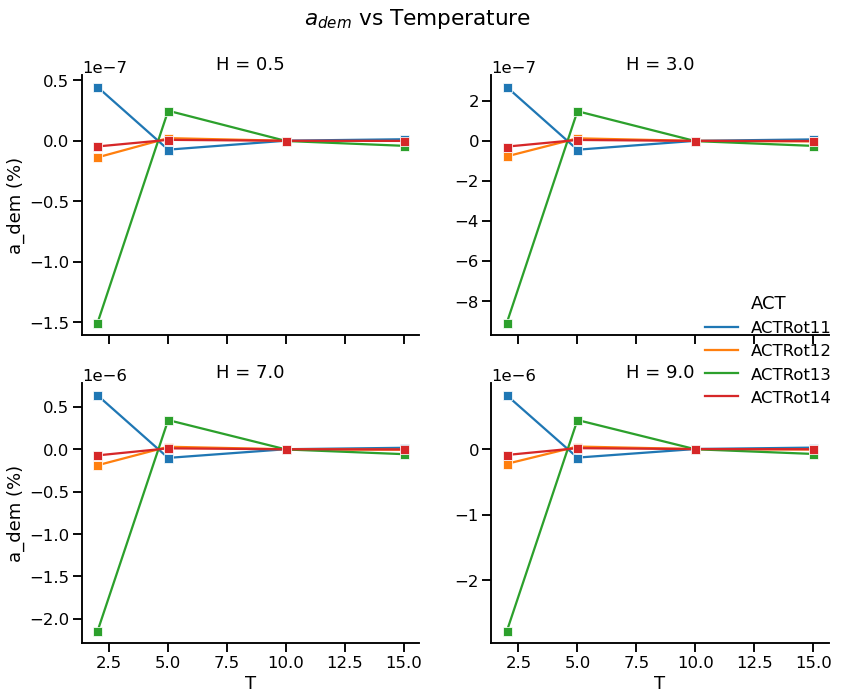

In [105]:
h = sns.relplot(x='T', 
                y='a_dem (%)',  # 'Sample Position (deg)', # 'Delta B (G)', # 
                data = final_df,
                col='H', col_wrap=2, kind='line', marker='s',
                ci=None, 
                hue ='ACT',
                facet_kws={'sharey':False})
h.fig.suptitle('$a_{dem}$ vs Temperature')
#h._legend.remove()

plt.tight_layout()

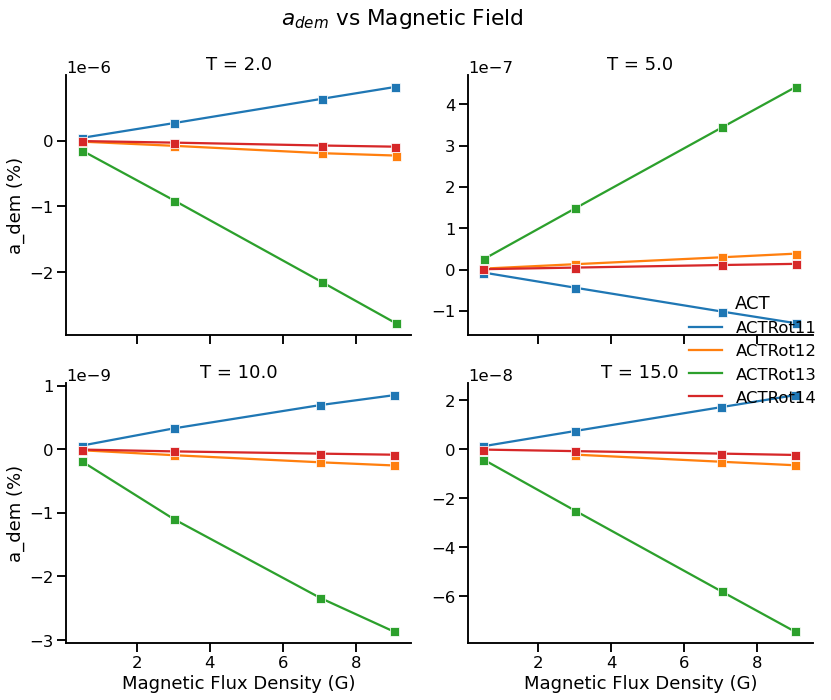

In [106]:
h = sns.relplot(x='Magnetic Flux Density (G)', y='a_dem (%)', data = final_df,
                col='T',  col_wrap=2, kind='line', marker='s', 
                ci=None, hue ='ACT', facet_kws={'sharey':False})
h.fig.suptitle('$a_{dem}$ vs Magnetic Field')
#h._legend.remove()
plt.tight_layout()

### Save the Results

In [107]:
final_df.to_csv('AMRO_combined_demag_amplitudes.csv', sep=',')


### Plot Amplitudes FOR THE THESIS

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_30796\952245509.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Label'] = np.where(plot_df['ACT'] == "ACTRot11",


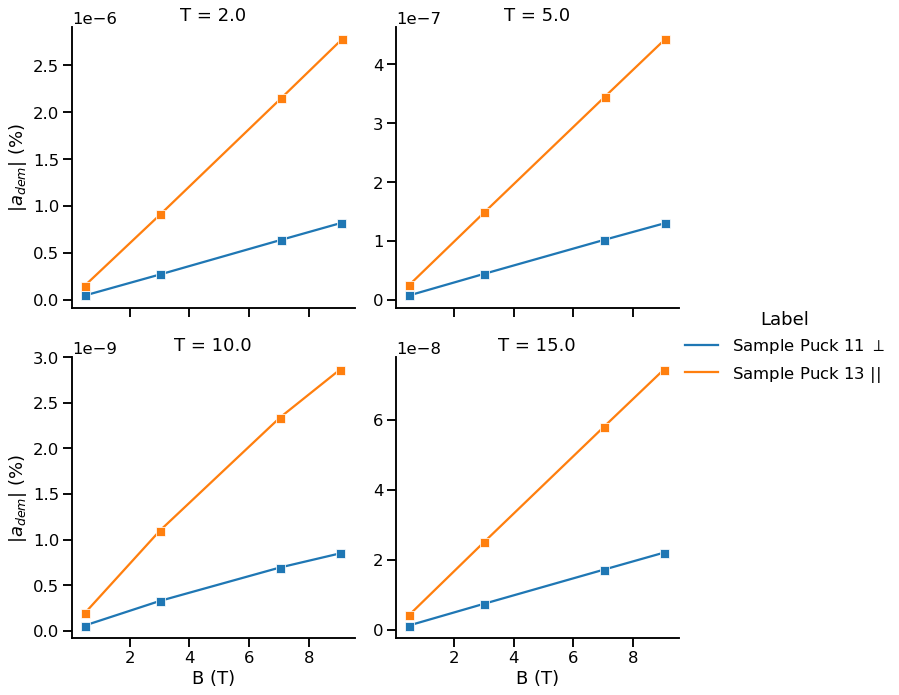

In [114]:
x_label =  'B (T)'# 'Magnetic Flux Density (G)'
col_label = 'T'
final_df[x_label] = final_df['Magnetic Flux Density (G)']#/10000

q='ACT in ("ACTRot11", "ACTRot13")'
plot_df = final_df.query(q)
plot_df['Label'] = np.where(plot_df['ACT'] == "ACTRot11",
                                  r'Sample Puck 11 $\perp$',
                                  r'Sample Puck 13 $||$'
                                 )
g = sns.relplot(x=x_label, y='abs. a_dem (%)', data = plot_df,
                col =col_label, hue = 'Label', kind='line', col_wrap=2,
                marker='s', ci=None, facet_kws={'sharey':False})#, hue='M')

# g.fig.suptitle(r'$|a_{dem}|$ vs. B', fontsize=30)#, y=1.03)
g.set_ylabels(r"$|a_{dem}|$ (%)")

# # Adjust the legend labels
fig_legend = g._legend
# fig_legend.remove()
# #fig_legend.set_bbox_to_anchor([0.98, 0.725])
# geos = ['Perp', 'Para', 'Para','Perp']
# for i,t in enumerate(fig_legend.texts):
#     t.set_text(t.get_text()+", "+geos[i])
# plt.tight_layout()
# plt.show()
g.fig.savefig('Demag Amplitudes vs B.pdf'.format(x_label), dpi=300, transparent=False, bbox_inches='tight')


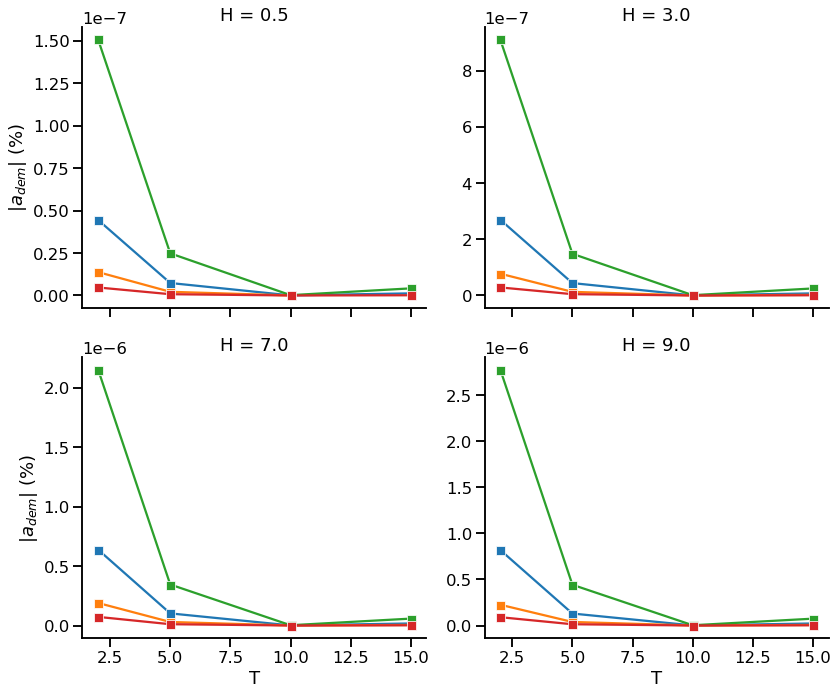

In [109]:
x_label = 'T'
col_label = 'H'


g = sns.relplot(x=x_label, y='abs. a_dem (%)', data = final_df,
                col =col_label, hue = 'ACT', kind='line', col_wrap=2,
                marker='s', ci=None, facet_kws={'sharey':False})#, hue='M')

# g.fig.suptitle(r'$|a_{dem}|$ vs. T', fontsize=30)#, y=1.03)
g.set_ylabels(r"$|a_{dem}|$ (%)")

# # Adjust the legend labels
fig_legend = g._legend
fig_legend.remove()
# #fig_legend.set_bbox_to_anchor([0.98, 0.725])
# geos = ['Perp', 'Para', 'Para','Perp']
# for i,t in enumerate(fig_legend.texts):
#     t.set_text(t.get_text()+", "+geos[i])
plt.tight_layout()
# plt.show()
g.fig.savefig('Demag Amplitudes vs {}.pdf'.format(x_label), dpi=300, transparent=False, bbox_inches='tight')


## Trouble with MR res vs AMRO res

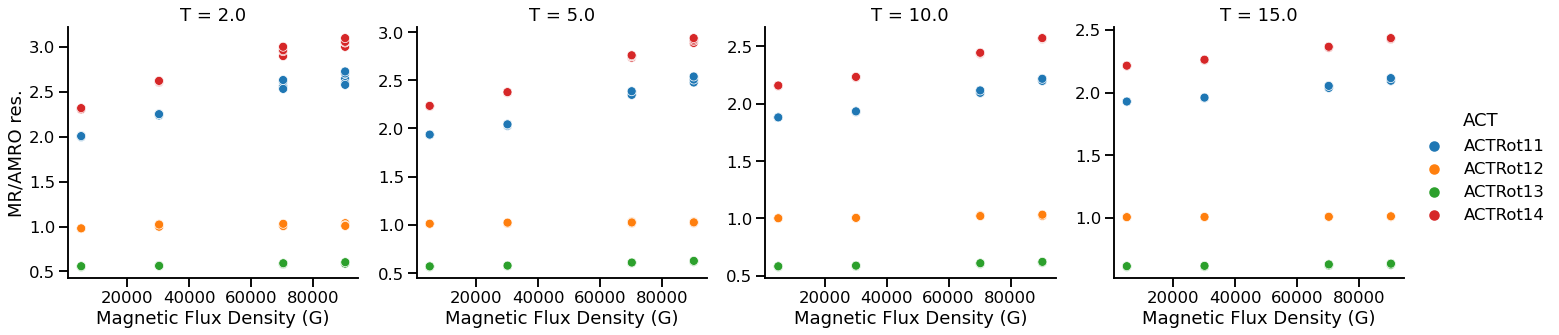

In [41]:
checkdf = amro_angles_mag_B_df.copy()
checkdf['MR/AMRO res.'] = checkdf['Cheb. MR Res.'] / checkdf['Res. ch2 (ohm-cm)']

sns.relplot(x='Magnetic Flux Density (G)', y='MR/AMRO res.',data = checkdf, hue='ACT',  col='T',facet_kws={'sharey':False, 'sharex':False})